# Exploratory Data Analysis Notebook

This notebook is designed to explore the dataset that was provided, assess its quality (images and labels), and identify any potential preprocessing steps that could be useful (even necessary) before training any model.

In [42]:
# Importing the required libraries

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import pickle

sys.path.append(os.path.abspath(os.path.join('../data')))
sys.path.append(os.path.abspath(os.path.join('../src')))

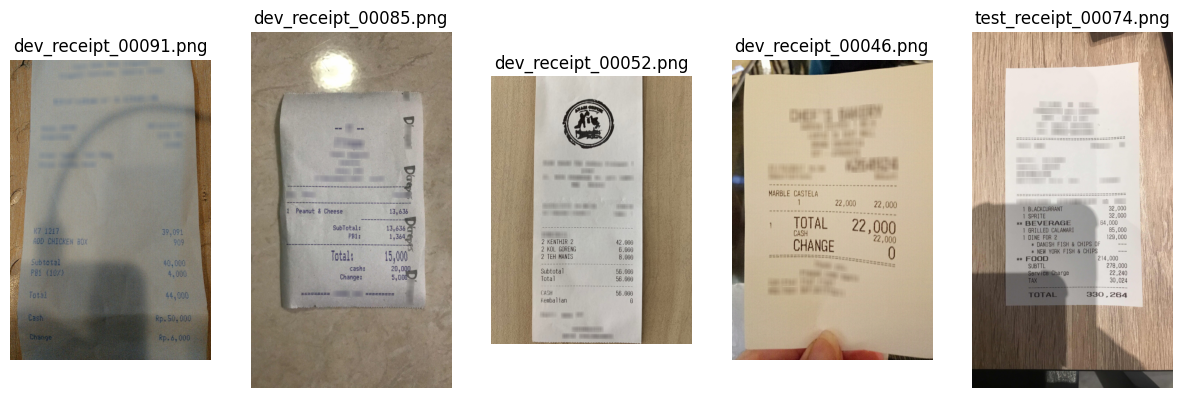

In [6]:
# Visualising some sample images from the dataset
data_dir = '../data/images/'

# Display the 5 first sample images from the dataset
n_images = 5
image_files = os.listdir(data_dir)[:n_images]

plt.figure(figsize=(15, 5))
for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(data_dir, image_file))
    plt.subplot(1, n_images, i + 1)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')
plt.show()

The sample images above clearly show that the dataset contains a variety of receipt formats, fonts, constrasts, background colors, and lighting conditions. 

We can comment on the images:
- Image dev_receipt_00091.png: This receipt shows poor contrast between the text and the receipt background. It also has some shadows and lighting variations that could make text recognition more challenging. Finally, the receipt is on a brownish surface, which could introduce additional noise, but also help in segmenting the receipt from the background, if that is a lead we want to explore by the way.
- Image dev_receipt_00085.png: This receipt has a cleaner appearance with better contrast between the text and the receipt background. It does not have significant shadows or lighting issues, making it easier for OCR models to recognize the text. Yet, the receipt seems to be slightly crumpled, but not on the entire surface.
- Image dev_receipt_00052.png: Though the receipt has good contrast, is well-lit, and not crumpled, it has a logo at the top that could potentially interfere with text recognition if the model is not trained to handle such cases.
- and so on for the other images...

We can note that all receipts contain blurred areas, which are likely to infer with model training and performance. We will probably need to address this issue in our preprocessing steps. TBC

Having also explored the dataset, we can display other images that show different challenges, such as:
- Receipts that are skewed or rotated: dev_receipt_00002.png, etc.
- Receipts with handwritten notes/markings: dev_receipt_00016.png, etc.
- Receipts with significant crumpling or folds: dev_receipt_00026.png, etc.
- Receipts that are poorly lit: dev_receipt_00043.png, etc.

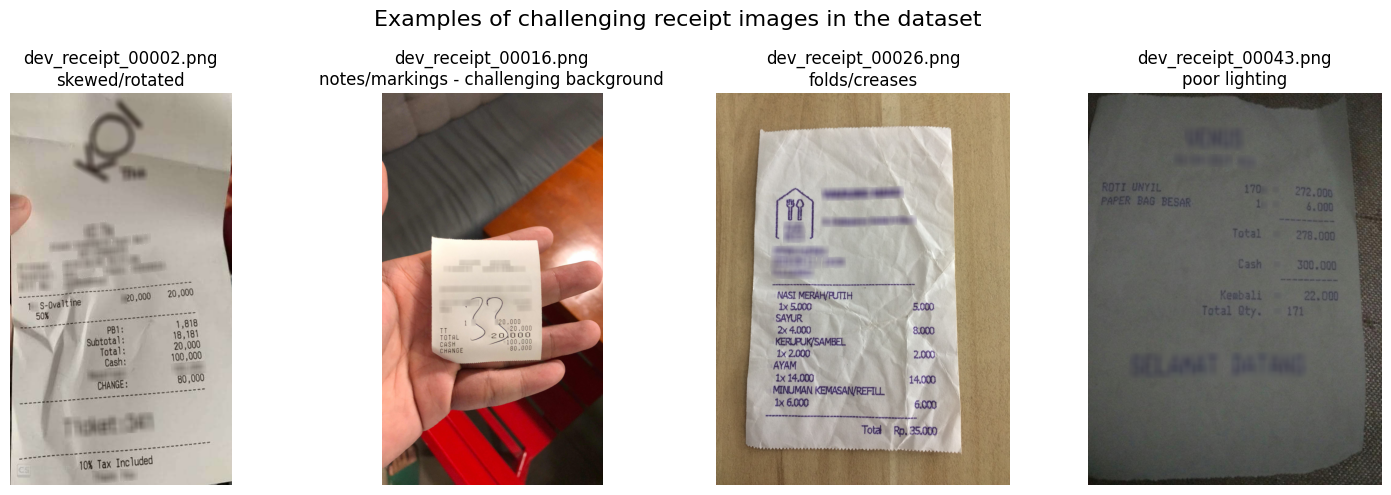

In [14]:
# Display receipts dev_receipt_00016.png, dev_receipt_00026.png, dev_receipt_00043.png
sample_images = ['dev_receipt_00002.png', 'dev_receipt_00016.png', 'dev_receipt_00026.png', 'dev_receipt_00043.png']
issues = ['skewed/rotated', 'notes/markings - challenging background', 'folds/creases', 'poor lighting']
titles = [f"{img}\n{issue}" for img, issue in zip(sample_images, issues)]
plt.figure(figsize=(15, 5))
for i, image_file in enumerate(sample_images):
    img = Image.open(os.path.join(data_dir, image_file))
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.axis('off')
plt.suptitle('Examples of challenging receipt images in the dataset', fontsize=16)
plt.tight_layout()
plt.savefig('../reports/figures/challenging_receipt_images.png')
plt.show()

We can also explore the labels provided in the dataset to assess their quality and consistency. This includes checking for:
- Completeness: Are all receipts labeled? Are there any missing labels?
- Format consistency: What do the annotations look like? Are they in a consistent format across all labels?

In [44]:
# Extract the annotations from the pkl file

with open('../data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

print(metadata.keys())  # Display the keys in the metadata dictionary

Index(['file_name', 'split_origin', 'words', 'bboxes', 'full_text'], dtype='object')


In [ ]:
# Ensure that each file_name in metadata has a corresponding split_origin, words, bboxes, full_text entry
file_names = metadata['file_name']
split_origins = metadata['split_origin']
words_list = metadata['words']
bboxes_list = metadata['bboxes']
full_texts = metadata['full_text']

for i, file_name in enumerate(file_names):
    # Check that the file exists in the data directory
    assert file_name in os.listdir(data_dir), f"File name {file_name} not found in metadata."
    # Check that the split_origin, words, bboxes, full_text entries are not empty
    assert split_origins[i] is not None, f"Split origin missing for {file_name}."
    assert words_list[i] is not None, f"Words missing for {file_name}."
    assert bboxes_list[i] is not None, f"BBoxes missing for {file_name}."
    assert full_texts[i] is not None, f"Full text missing for {file_name}."
    
print("There are no missing entries in the metadata for the files present in the data directory.")

There are no missing entries in the metadata for the files present in the data directory.


Annotation file name: dev_receipt_00000.png
Annotation split origin: dev
Annotation full text: 1 REAL GANACHE 16,500 1 EGG TART 13,000 1 PIZZA TOAST 16,000 TOTAL 45,500 CASH 50,000 CHANGE 4,500
Number of annotated words: 18
All annotated words: ['1', 'REAL', 'GANACHE', '16,500', '1', 'EGG', 'TART', '13,000', '1', 'PIZZA', 'TOAST', '16,000', 'TOTAL', '45,500', 'CASH', '50,000', 'CHANGE', '4,500']
All bounding boxes: [{'x2': 194, 'y3': 586, 'x3': 194, 'y4': 586, 'x1': 176, 'y1': 556, 'x4': 176, 'y2': 556}, {'x2': 266, 'y3': 586, 'x3': 266, 'y4': 586, 'x1': 202, 'y1': 554, 'x4': 202, 'y2': 554}, {'x2': 372, 'y3': 586, 'x3': 372, 'y4': 586, 'x1': 272, 'y1': 554, 'x4': 272, 'y2': 554}, {'x2': 664, 'y3': 584, 'x3': 664, 'y4': 584, 'x1': 580, 'y1': 552, 'x4': 580, 'y2': 552}, {'x2': 194, 'y3': 620, 'x3': 194, 'y4': 620, 'x1': 176, 'y1': 590, 'x4': 176, 'y2': 590}, {'x2': 252, 'y3': 620, 'x3': 252, 'y4': 620, 'x1': 204, 'y1': 588, 'x4': 204, 'y2': 588}, {'x2': 320, 'y3': 618, 'x3': 320, 'y4': 

Text(0.5, 1.0, 'Sample Image: dev_receipt_00000.png with Annotations')

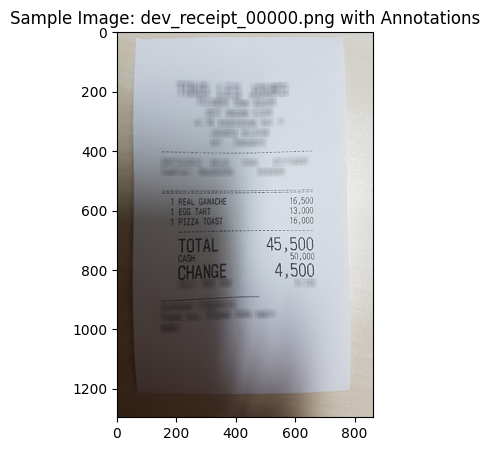

In [ ]:
# Extract annotations for dev image sample '00000'
sample_image_id = 'dev_receipt_00000.png'

# Extract the image number from the file name
sample_image_number = sample_image_id.split('_')[-1].split('.')[0]
sample_image_number_int = int(sample_image_number)

annot_file_name = metadata['file_name'][sample_image_number_int]
annot_split_origin = metadata['split_origin'][sample_image_number_int]
annot_words = metadata['words'][sample_image_number_int]
annot_bboxes = metadata['bboxes'][sample_image_number_int]
annot_full_text = metadata['full_text'][sample_image_number_int]

print(f"Annotation file name: {annot_file_name}")
print(f"Annotation split origin: {annot_split_origin}")
print(f"Annotation full text: {annot_full_text}")
print(f"Number of annotated words: {len(annot_words)}")
print(f"All annotated words: {annot_words}")
print(f"All bounding boxes: {annot_bboxes}")


plt.figure(figsize=(5, 5))
img = Image.open(os.path.join(data_dir, sample_image_id))
plt.imshow(img)
plt.title(f"Sample Image: {sample_image_id} with Annotations")

---

### Background Removal

A first approach to tackle the background issue could be to convert the images to grayscale, then apply a clustering algorithm (e.g., K-means) to segment the receipt from the background. This would help in isolating the text area and reducing noise from the background.

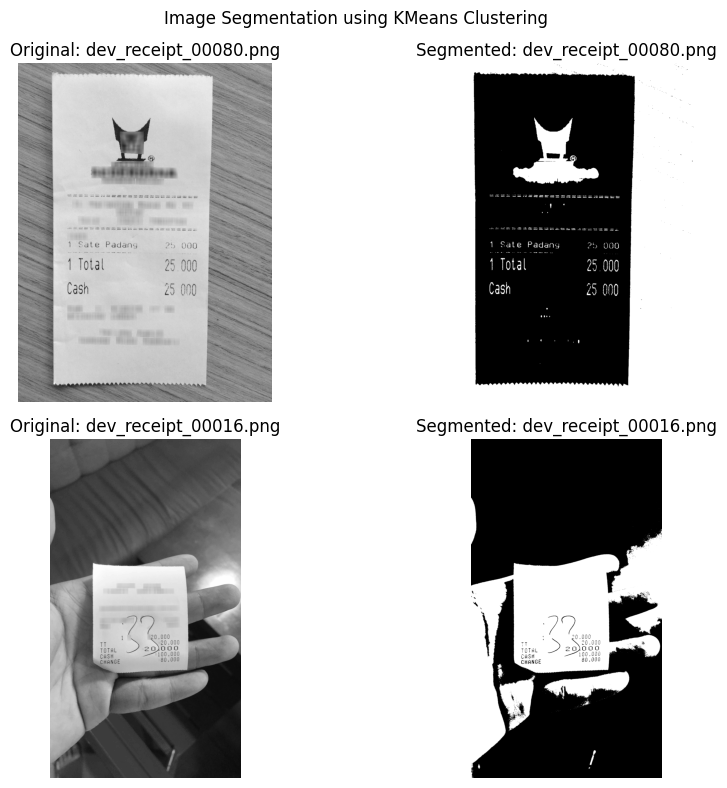

In [35]:
# Try segmentation on a sample image with kmeans to get a first idea of how it may perform

images_considered = ['dev_receipt_00080.png', 'dev_receipt_00016.png']
   
# Plot original and segmented images (side by side, each sample in a row)
plt.figure(figsize=(10, 8))
for i, image_file in enumerate(images_considered):
    img = cv2.imread(os.path.join(data_dir, image_file))
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_reshaped = img_grayscale.reshape((-1, 1))
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(img_reshaped)
    segmented_img = kmeans.labels_.reshape(img_grayscale.shape)
    
    plt.subplot(len(images_considered), 2, 2*i + 1)
    plt.imshow(img_grayscale, cmap='gray')
    plt.title(f'Original: {image_file}')
    plt.axis('off')
    
    plt.subplot(len(images_considered), 2, 2*i + 2)
    plt.imshow(segmented_img, cmap='gray')
    plt.title(f'Segmented: {image_file}')
    plt.axis('off')  
    
plt.suptitle(f'Image Segmentation using KMeans Clustering')
plt.tight_layout()
plt.savefig('../reports/figures/sample_image_segmentation_kmeans.png')
plt.show()

Another approach could be to apply edge detection techniques (like Canny edge detection) to identify the boundaries of the receipt and crop out the background.

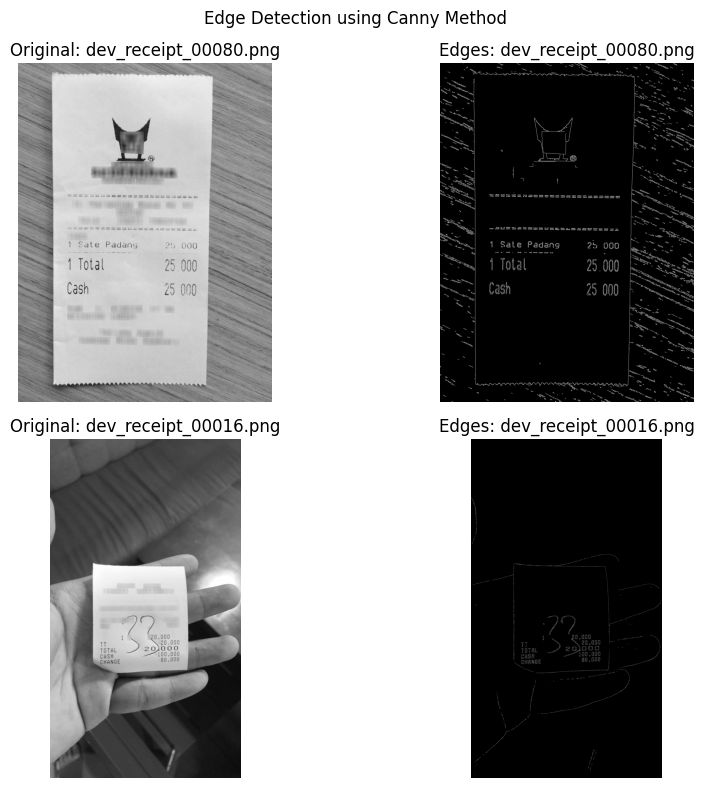

In [ ]:
# Canny Edge Detection on the same sample images

# Plot original and edge-detected images (side by side, each sample in a row)
plt.figure(figsize=(10, 8))
for i, image_file in enumerate(images_considered):
    img = cv2.imread(os.path.join(data_dir, image_file))
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img_grayscale, 100, 200)
    
    plt.subplot(len(images_considered), 2, 2*i + 1)
    plt.imshow(img_grayscale, cmap='gray')
    plt.title(f'Original: {image_file}')
    plt.axis('off')
    
    plt.subplot(len(images_considered), 2, 2*i + 2)
    plt.imshow(edges, cmap='gray')
    plt.title(f'Edges: {image_file}')
    plt.axis('off')
    
plt.suptitle(f'Edge Detection using Canny Method')
plt.tight_layout()
#plt.savefig('../reports/figures/sample_image_edge_detection_canny.png')
plt.show()

Based on the canny edge detection results, we can create a mask to isolate the receipt from the background. To do that, we can find the contours of the detected edges, identify the most "rectangular" contour (which should correspond to the receipt), and create a binary mask that highlights this area. We can then apply this mask to the original image to remove the background.

One last approach could be to apply a thresholding technique (like Otsu's method) to create a binary mask that separates the receipt from the background based on pixel intensity values.

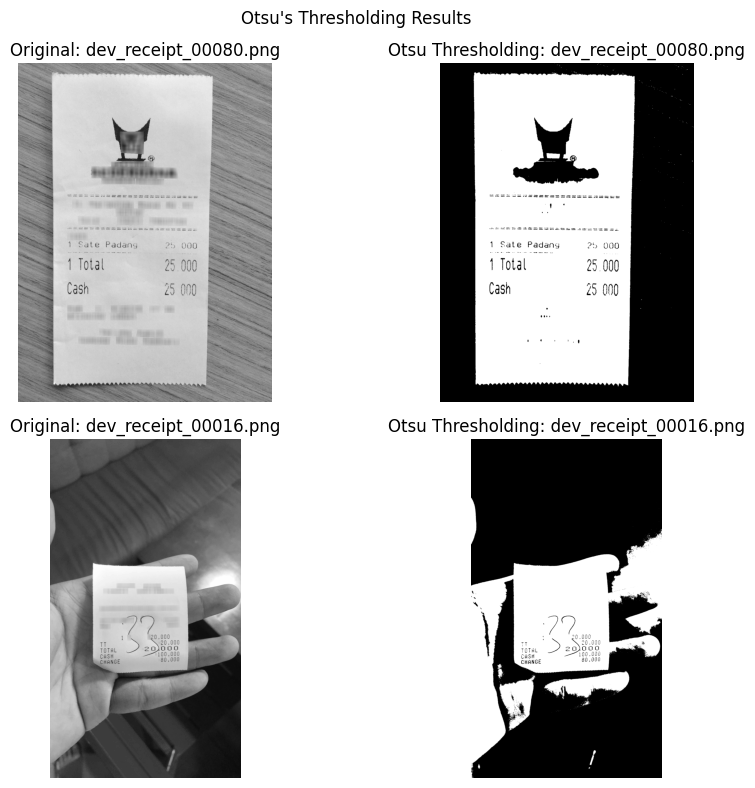

In [41]:
# Otsu's Thresholding on the considered sample images

plt.figure(figsize=(10, 8))
for i, image_file in enumerate(images_considered):
    img = cv2.imread(os.path.join(data_dir, image_file))
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, otsu_thresh = cv2.threshold(img_grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    plt.subplot(len(images_considered), 2, 2*i + 1)
    plt.imshow(img_grayscale, cmap='gray')
    plt.title(f'Original: {image_file}')
    plt.axis('off')
    
    plt.subplot(len(images_considered), 2, 2*i + 2)
    plt.imshow(otsu_thresh, cmap='gray')
    plt.title(f'Otsu Thresholding: {image_file}')
    plt.axis('off')
    
plt.suptitle(f'Otsu\'s Thresholding Results')
plt.tight_layout()
#plt.savefig('../reports/figures/sample_image_otsu_thresholding.png')
plt.show()

---

In [ ]:
# We focus on the development set for this exploratory data analysis. It contains 100 images that start with "dev_receipt_".
dev_image_files = [f for f in os.listdir(data_dir) if f.startswith('dev_receipt_')]
print(f"Number of images in the development set: {len(dev_image_files)}")

Number of images in the development set: 100
